# On Time Performance of Flights
                                                                            by Jong-Chin Lin

The data downloaded from http://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time contains information about the on time performance of domestic flights in the United States.

###Preliminary statistics:
To get a sense of the datasets, lets see the first couple of rows of the data for Januaray 2014:

In [1]:
%pylab inline
import pandas as pd
#from datetime import datetime

input_file = "2014-01.csv"
data = pd.read_csv(input_file)
pd.set_option('display.max_columns', None)
print data[:2]

Populating the interactive namespace from numpy and matplotlib
   YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK     FL_DATE UNIQUE_CARRIER  \
0  2014        1      1            28            2  2014-01-28             MQ   
1  2014        1      1            29            3  2014-01-29             MQ   

   AIRLINE_ID CARRIER  FL_NUM  ORIGIN_AIRPORT_ID  ORIGIN_AIRPORT_SEQ_ID  \
0       20398      MQ    3419              10397                1039705   
1       20398      MQ    3419              10397                1039705   

   ORIGIN_CITY_MARKET_ID ORIGIN ORIGIN_CITY_NAME  DEST_AIRPORT_ID  \
0                  30397    ATL      Atlanta, GA            12953   
1                  30397    ATL      Atlanta, GA            12953   

   DEST_AIRPORT_SEQ_ID  DEST_CITY_MARKET_ID DEST DEST_CITY_NAME  CRS_DEP_TIME  \
0              1295302                31703  LGA   New York, NY          1150   
1              1295302                31703  LGA   New York, NY          1150   

   DEP_TIME  DE

One of the most important values to measure the on time performance is the difference between the actual arrival time and the scheduled arrival time, which is indicated by column ARR_DELAY. Here let us first focus on ARR_DELAY for different airlines. To do this, I filter out rows that have missing value in ARR_DELAY, and group the data by airlines (UNIQUE_CARRIER).

The following code would show the average arrival delay time for flights operated by different airlines in January 2014, and the distribution of arrival delay times (ARR_DELAY) of all AA flights in the month. Note that positive ARR_DELAY means a flight arrived later than its scheduled arrival time, and negative ARR_DELAY means a flight arrived earlier than its scheduled arrival time.

Average arrival delay time (min) in January 2014
UNIQUE_CARRIER
AA                 6.022626
AS                -3.973786
B6                25.271179
DL                13.489790
EV                19.692495
F9                22.431379
FL                10.938127
HA                -0.448477
MQ                18.825596
OO                 8.270629
UA                 9.886219
US                 4.075689
VX                 0.970266
WN                17.500161
Name: ARR_DELAY, dtype: float64

Histogram of arrival delay time for American Airlines (AA) in January 2014


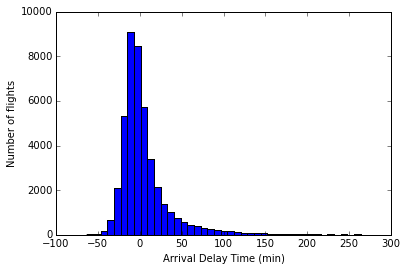

In [2]:
def plotDistribution(flights_arrived, airline):
    subplot(111)
    plt.hist(flights_arrived.get_group(airline).ARR_DELAY.values, 200)
    plt.axis([-100, 300, 0, 10000])
    xlabel('Arrival Delay Time (min)');
    ylabel('Number of flights');
    show()

# Group arrival flights (consider only those that have non-missing values in ARR_DELAY)
flights_arrived = data[pd.isnull(data['ARR_DELAY']) == False].groupby('UNIQUE_CARRIER')
print "Average arrival delay time (min) in January 2014"
print flights_arrived.mean().ARR_DELAY

# Plot distribution of delay time
print "\nHistogram of arrival delay time for American Airlines (AA) in January 2014"
plotDistribution(flights_arrived, 'AA')

The distribution of arrival delay time is centered at a value less than zero but with a longer tail towards the positive side, resulting in a positive delay time in average.

### Airline dependence of on time performance
To study the delay time more thoroughly, let us include data from all other months in 2014. In addition to calculating average ARR_DELAY, I would also calculate the percentage of flights that got cancelled for each airline, which is relevant to how an airline performs but is not reflected in the delay time.

On Time Performance:
                NumFlights  NumCancelled  NumArrived  CancelRate  \
UNIQUE_CARRIER                                                     
AA                  537697          8457      527283    0.015728   
AS                  160257           759      159055    0.004736   
B6                  249693          6076      242927    0.024334   
DL                  800375          6502      792500    0.008124   
EV                  686021         34128      649765    0.049748   
F9                   85474           357       84968    0.004177   
FL                   79495          1516       77818    0.019070   
HA                   74732           158       74496    0.002114   
MQ                  392701         21156      370524    0.053873   
OO                  613030         18308      593074    0.029865   
UA                  493528          7330      484992    0.014852   
US                  414665          6737      407183    0.016247   
VX                   57510 

/Users/jongchinlin/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1159: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


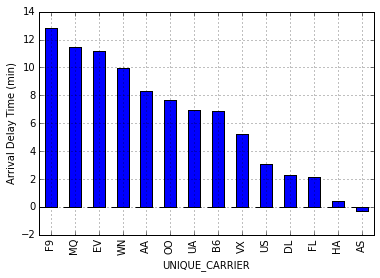

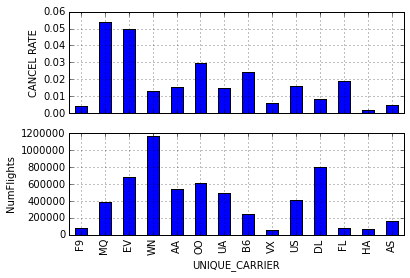

In [3]:
def plotDelayTime(data, xname):
    # Plot histogram of arrival delay time
    subplot(111)
    data.sort(['DelayArrMean'],ascending=False).DelayArrMean.plot(kind='bar')
    xlabel(xname);
    ylabel('Arrival Delay Time (min)');
    show()

def plotCancelRate(data, xname):
    # Plot histogram of cancellation rate
    subplot(211)
    data.sort(['DelayArrMean'],ascending=False).CancelRate.plot(kind='bar')
    xlabel(xname);
    ylabel('CANCEL RATE');
    subplot(212)
    data.sort(['DelayArrMean'],ascending=False).NumFlights.plot(kind='bar')
    ylabel('NumFlights');
    show()
    
def readData(input_file, col, colGroup):
    data = pd.read_csv(input_file)
    data['hourCRS_DEP'] = (data.CRS_DEP_TIME / 100).apply(lambda x: floor(x))
    
    # Group all flights by airlines
    flights = data.groupby(colGroup)
    
    # Group cancelled flights by airlines
    flights_cancelled = data[data['CANCELLED'] == 1].groupby(colGroup)
    
    # calculate cancellation rate
    perform = flights.size()
    perform = pd.DataFrame(perform)
    perform.columns = ['NumFlights']
    
    perform['NumCancelled'] = flights_cancelled.size()    
    
    # Group arrival flights (consider only those that have non-missing values in ARR_DELAY)
    flights_arrived = data[pd.isnull(data[col]) == False].groupby(colGroup)
    
    # Calculate sum of delay minutes for arrival flights
    arrSum = flights_arrived.sum()
    
    perform['NumArrived'] = flights_arrived.size()
    
    perform['DelayArrSum'] = arrSum.ARR_DELAY
    perform['DelayArrSum2'] = flights_arrived.apply(lambda x: x.ARR_DELAY.dot(x.ARR_DELAY))
    
    # Dissect ARR_DELAY into different factors
    if col == 'CARRIER_DELAY':
        perform['CarrierSum'] = arrSum.CARRIER_DELAY
        perform['WeatherSum'] = arrSum.WEATHER_DELAY
        perform['NasSum'] = arrSum.NAS_DELAY
        perform['SecuritySum'] = arrSum.SECURITY_DELAY
        perform['LateSum'] = arrSum.LATE_AIRCRAFT_DELAY
    
    return perform

col = 'ARR_DELAY'
colGroup = 'UNIQUE_CARRIER'
year = 2014
input_file = str(year) + '-01.csv'
performance = readData(input_file, col, colGroup)

perform_monthly = [performance]

nmonth = 12
for i in range(1, nmonth):
    input_file = str(year) + '-' + str(i+1).zfill(2) + '.csv'
    temp = readData(input_file, col, colGroup)
    perform_monthly.append(temp)
    performance += temp
    
print 'On Time Performance:'
    
performance['CancelRate'] = performance.NumCancelled / performance.NumFlights
    
# Average delay minutes for arrival flights
performance['DelayArrMean'] = performance.DelayArrSum / performance.NumArrived
performance['DelayArrVar'] = performance.DelayArrSum2 / (performance.NumArrived-1)
performance['DelayArrStd'] = performance.DelayArrVar.apply(np.sqrt)
performance['DelayArrSte'] = performance.DelayArrStd / performance.NumArrived.apply(np.sqrt)

print performance[['NumFlights', 'NumCancelled', 'NumArrived', 'CancelRate', 'DelayArrMean',
                   'DelayArrStd', 'DelayArrSte']]
plotDelayTime(performance, colGroup)
plotCancelRate(performance, colGroup)

The table above shows the on time performance for different airlines in 2014. The columns represent number of scheduled flights, number of cancelled flights, number of arrival flights, cancellation rate, mean, standard deviation, and standard error of arrival delay time, respectively. The plots show the mean arrival time, cancellation rate, and number of scheduled flights for different airlines.

Among the airlines shown above, Alaska Airlines (AS) has the best on time performance in 2014 with a negative arrival delay time along with a small cancellation rate. Three of the bottem four airlines (B6, EV, MQ), with most delay times, also have the most cancelled flights relative to their scheduled flights. The calculation of correlation coefficients (see below) indeed show that the mean arrival delay time and cancellation rate are strongly correlated (corr = 0.54) with each other, which is also statistically significant according to the t-statistics, t = r * sqrt((n-2)/(1-r^2)), for testing significance of a correlation coefficient. With n = 14 and r = 0.54, we can get t = 2.2, resulting in the p-value = 0.046 with two-tailed test.

In [4]:
print "Correlation coefficients between delay time, cancellation rate, and number of flights:\n"
print "corr(DelayArrMean, CancelRate):", performance.DelayArrMean.corr(performance.CancelRate)
print "corr(CancelRate, NumFlights):", performance.CancelRate.corr(performance.NumFlights)
print "corr(DelayArrMean, NumFlights):", performance.DelayArrMean.corr(performance.NumFlights)

Correlation coefficients between delay time, cancellation rate, and number of flights:

corr(DelayArrMean, CancelRate): 0.537332329328
corr(CancelRate, NumFlights): 0.26352539549
corr(DelayArrMean, NumFlights): 0.337423617573


From the plot above, it would be interesting to see if the on time performance is related to the number of flights that an airline operated since the two airlines with best on time performance (Alaska Airlines (AS) and Hawaiian Airlines (HA)) happened to be among the airlines that operated the fewest flights during the year. They also have the smallest standard deviations in the arrival delay time among all airlines. However, despite both the cancellation rate and mean arrival delay time are weakly correlated with the number of scheduled flights, the correlations are not statistically significant according to the significance test.

### On time performance depends on time of year
Another interesting thing to investigate is if the performance depends on the time of the year. The following shows the monthly performance for different airlines in 2014.

UNIQUE_CARRIER         AA        AS         B6        DL         EV  \
1                8.300543 -0.300682   6.912538  2.318125  11.190911   
2                6.971384 -2.217602  13.932259  5.054391  17.846803   
3                4.565388 -2.041514   4.465426  2.354255  10.332720   
4                3.248359 -2.904211   5.258469  1.451788   8.629489   
5                7.202130 -1.711219   4.638626  2.776831  11.616991   
6               16.793722  1.695575   5.288243  5.307124  16.962241   
7               11.945045  2.601783  17.855311  0.721677   9.679521   
8               11.567011  2.212452   5.140478  2.120783   9.804718   
9                4.473487  0.131911  -1.668178  0.984946   9.112532   
10               9.473344 -1.209768   0.591082 -0.233983   9.748419   
11               6.352611 -0.672675   1.956760 -0.045252   4.186683   
12              10.097347  2.799644   2.423024 -3.594645   7.821854   

UNIQUE_CARRIER         F9        FL        HA         MQ         OO  \
1    

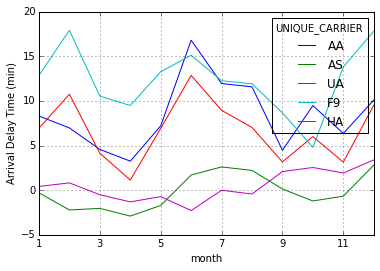

In [5]:
def plotTimeSeries(perform_monthly):
    delayArrSeries = pd.DataFrame(perform_monthly[0].DelayArrSum /
                                  perform_monthly[0].NumArrived)
    delayArrSeries.columns = ['1']
    
    for i in range(1,len(perform_monthly)):
        delayArrSeries[str(i+1)] = perform_monthly[i].DelayArrSum/perform_monthly[i].NumArrived
    
    delayArrSeries = delayArrSeries.T

    print delayArrSeries    
    dAS = delayArrSeries[['AA','AS','UA','F9','HA']].plot()
    dAS.set_xlabel("month")
    dAS.set_ylabel("Arrival Delay Time (min)")

plotTimeSeries(perform_monthly)

The figure above shows monthly mean arrival delay time for AA, AS, UA, F9, and HA in 2014. It seems that flights in summer (June and July) and winter (December, January, and Feburary) had longer delay times than those in spring (April) and fall (September), except for HA. Flights of Hawaiian Airlines (HA) had longer delay time in winter than in summer. Is the performance related to the peak season and off-peak season travels for respective airlines? It may be premature to draw a conclusion based on a single year data. More years of data may be needed for investigating seasonal changes in the on time performance in general.

### Predicting on time performance

To see what other factors or features are related to the on time performance, we may need a systematic way to find the important features and how they affect the delay time. Here let us see if we can predict delay time based on historical data. Since the data contain both numeric features and categorical features (such as UNIQUE_CARRIER), one good approach would be using the gradient boosting method, which produces a good prediction model in the form of an ensemble of weak prediction models, such as decision trees.

Here let us use the data in 2014 as training sets, and predict the on time performance for flights in 2015. To do this, we can first randomly extract a smaller sample from the 2014 data for the training to save computation time, and test the trained model on an out-of-sample test set from 2014 data. I also selected the potential relevant features (as shown in the following code) for the training. One thing to do before the training is to preprocess the data, such as airports location and airlines. I would transform the airports ID to their geospatial data, i.e. latitude and longtude. Also I would transform UNIQUE_CARRIER to features that are binary because of the limitation of Gradient Boosting Regressor in sklean using Python when dealing with categorical features.

The following code contains self-defined functions for processing data for training: 

In [6]:
from sets import Set
from sklearn.metrics import mean_squared_error

def sampleData(input_file, col = 'ARR_DELAY', ratio = 0.01):
    # Randomly select a portion of data from input_file
    data = pd.read_csv(input_file)
    n = int(ratio * len(data)) # size of sample
    
    data2 = data[['YEAR', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER', 'FL_NUM',
                  'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'DISTANCE','ARR_DELAY']]
    data2 = data2[pd.isnull(data[col]) == False]
    
    # Randomly shuffle data
    temp = data2.reindex(np.random.permutation(data2.index))
    
    return temp[:n]

def lookupAirport(x, airports, key):
    # Helper function for looking up geospatial data of airports
    if x in airports.index:
        return airports.loc[x][key]
    else:
        #print x, np.nan
        return np.nan

def accDays(m):
    # Helper function for calculating day of year
    days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    if m == 1:
        return 0
    else:
        return days_in_month[m-1] + accDays(m-1)
    
def processData(data):
    # Convert scheduled departure and arrival time to minute of day
    data['hourCRS_DEP'] = (data.CRS_DEP_TIME / 100).apply(lambda x: floor(x))
    data['minCRS_DEP'] = data.CRS_DEP_TIME - data.hourCRS_DEP * 100
    data['CRS_DEP_in_minute'] = data['hourCRS_DEP']*60 + data['minCRS_DEP']
    
    data['hourCRS_ARR'] = (data.CRS_ARR_TIME / 100).apply(lambda x: floor(x))
    data['minCRS_ARR'] = data.CRS_ARR_TIME - data.hourCRS_ARR * 100
    data['CRS_ARR_in_minute'] = data['hourCRS_ARR']*60 + data['minCRS_ARR']
    
    # Convert date to day of year
    data['dayOfYear'] = data.MONTH.apply(lambda x: accDays(x)) + data.DAY_OF_MONTH
    
    # Convert airport location to geospacial data
    airports = pd.read_csv("airports.csv")
    
    airports = airports.set_index('iata')
    
    data['OriginLat'] = data.ORIGIN.apply(lambda x: lookupAirport(x, airports,'lat'))
    data['OriginLong'] = data.ORIGIN.apply(lambda x: lookupAirport(x, airports,'long'))
    data['DestLat'] = data.DEST.apply(lambda x: lookupAirport(x, airports,'lat'))
    data['DestLong'] = data.DEST.apply(lambda x: lookupAirport(x, airports,'long'))
    
    # Filter out rows that do not have geospatial information
    data = data[pd.isnull(data['OriginLat']) == False]
    data = data[pd.isnull(data['DestLat']) == False]

    # Convert UNIQUE_CARRIER to binary features
    data['FL'] = 0 # A fix for error when processing 2015 data where Airline FL is missing
    carriers = Set(data.UNIQUE_CARRIER)
    for carrier in carriers:
        data[carrier] = (data.UNIQUE_CARRIER == carrier).apply(lambda x: int(x))

    # Define ArrGroup as arrival delay group: -1 if ARR_DELAY < -15; 0 if -15 <= ARR_DELAY < 15;
    # 1 if 15 <= ARR_DELAY < 45, etc.
    #data['ArrGroup'] = data.ARR_DELAY.apply(lambda x: 0 if x < 15 else floor((x+15)/30)+1)
    data['ArrGroup'] = data.ARR_DELAY.apply(lambda x: 0 if x <= 15 else 1)
        
    # Return data with newly defined features
    data_new = data[['dayOfYear', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_DEP_in_minute',
                     'CRS_ARR_in_minute', 'OriginLat', 'OriginLong', 'DestLat',
                     'DestLong','AA', 'OO', 'DL', 'HA', 'WN', 'AS', 'US', 'B6', 'MQ', 'FL',
                     'F9', 'VX', 'EV', 'UA', 'ARR_DELAY','ArrGroup']]
    
    print "First five rows with newly defined features for training:"
    print data_new[:5]
    return data_new
    
def splitTV(data, n_fold = 5, col_y = -1):
    # Split data into a training set and a validation set
    m = int(len(data)/n_fold)
    print "\nNumber of data points:", len(data)
    
    temp = data.reindex(np.random.permutation(data.index))
    temp = temp.reset_index().values
    
    train = temp[m:]
    validate = temp[:m]
    y_train = train[:,col_y]
    X_train = train[:,1:-2]

    y_val = validate[:,col_y]
    X_val = validate[:, 1:-2]
    
    return (X_train, y_train, X_val, y_val)

def loadYearData(year, col = 'ARR_DELAY', ratio = 0.01):
    # Load sample data
    input_file = str(year) + '-01.csv'
    print('Reading data...')
    mlData = sampleData(input_file, col, ratio)

    nmonth = 12
    for i in range(1, nmonth):
        input_file = str(year) + '-' + str(i+1).zfill(2) + '.csv'
        temp = sampleData(input_file, col, ratio)
        mlData = mlData.append(temp, ignore_index=True)

    print('Processing data...')
    mlData = processData(mlData)
    
    return mlData

def plotPredict(y, y_pred):
    print "\nActual arrival delay time vs predicted arrival delay time"
    subplot(211)
    plt.axis([-100, 300, 0, 2000])
    xlabel('Arrival Delay Time (min)');
    ylabel('Number of flights');
    plt.hist(y, bins=np.arange(-100, 300 + 5, 5))
    plt.show()

    subplot(212)
    plt.axis([-100, 300, 0, 2000])
    xlabel('Arrival Delay Time (min)');
    ylabel('Number of flights');
    plt.hist(y_pred, bins=np.arange(-100, 300 + 5, 5))
    plt.show()

# Get sample data for training from a year of data
year = 2014
col = 'ARR_DELAY'
ratio = 0.01
mlData = loadYearData(year, col, ratio)

# Split sample data into training and validation sets
n_fold = 5
col_y = -2 # col_y = -2 if ARR_DELAY is predictor, else col_y = -1 if ArrGroup is predictor
(X_train, y_train, X_test, y_test) = splitTV(mlData, n_fold, col_y)

Reading data...
Processing data...
First five rows with newly defined features for training:
   dayOfYear  DAY_OF_WEEK  DISTANCE  CRS_DEP_in_minute  CRS_ARR_in_minute  \
0         27            1       447                360                456   
1         31            5       550                695                795   
2         16            4       866                820               1019   
3          4            6       725                960               1045   
4          1            3        86                613                660   

   OriginLat  OriginLong    DestLat    DestLong  AA  OO  DL  HA  WN  AS  US  \
0  39.997985  -82.891883  33.640444  -84.426944   0   0   1   0   0   0   0   
1  45.588722 -122.597500  37.619002 -122.374843   0   0   0   0   0   0   0   
2  40.788388 -111.977773  46.919349  -96.814989   0   1   0   0   0   0   0   
3  40.777243  -73.872609  41.785983  -87.752424   0   0   0   0   1   0   0   
4  33.942536 -118.408074  33.127231 -117.278727  

#### Training with gradient boosting regression
One of the parameters in the gradient boosting regression model that may influence the model's generalization ability is learning rate. Here I perform a 5-fold cross validation with grid search method on the training set to find the learning rate that minimize the mean squared error (MSE) of the arrival delay time of validation data. The model trained with optimized learning rate is then used to predict an out-of-sample test set extracted from data in the same year. The number of trees is set to 200, and other parameters are set to values shown in the code below.

In [7]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV

def outPredicted(regressor, X_train, y_train, X_val, y_val):
    # print information of predicted results
    y_val_pred = regressor.predict(X_val)
    y_train_pred = regressor.predict(X_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    print "\nRMSE(y_train, y_train_pred), RMSE(y_val, y_val_pred)"
    print rmse_train, rmse_val
    
    naive_pred = np.mean(y_train)
    naive_error = np.std(y_val - naive_pred)

    print "\nMean of y_train:", naive_pred
    print "Root mean squared error of naive prediction: ", naive_error
    #print "\nFeature importances:"
    #print regressor.feature_importances_
    
    return regressor

def cv_optimize(X, y, paramslist, n_est = 200, n_folds = 5):
    # Find best learning rate through cross validation using GridSearchCV in sklearn
    clf = GradientBoostingRegressor(n_estimators = n_est, max_depth = 5, min_samples_split= 2,
                                    loss = 'ls')
    parameters = {"learning_rate": paramslist}
    gs = GridSearchCV(clf, param_grid=parameters, scoring='mean_squared_error',cv = n_folds)
    gs.fit(X, y)
    return gs.best_params_, gs.best_score_

def cv_and_fit(X, y, paramslist, n_est = 200, nf = 5):
    # Get optimized model from cross validation and fit the optimized model to training set
    bp, bs = cv_optimize(X, y, paramslist, n_est = 200, n_folds = nf)
    print "BP, BS", bp, bs
    clf = GradientBoostingRegressor(n_estimators = n_est, max_depth = 5, min_samples_split=2,
                                    learning_rate = bp['learning_rate'], loss = 'ls')
    clf.fit(X, y)
    return clf

# Training and cross validation
print "Cross validating..."
print "Size of training set:", len(y_train)
print "Size of out-of-sample test set:", len(y_test)
n_est = 200
regressor = cv_and_fit(X_train, y_train, np.logspace(-2, 0, num=5))
outPredicted(regressor, X_train, y_train, X_test, y_test)

Cross validating...
Size of training set: 46473
Size of out-of-sample test set: 11618
BP, BS {'learning_rate': 0.031622776601683791} -1404.01930151

RMSE(y_train, y_train_pred), RMSE(y_val, y_val_pred)
35.8949028708 38.17130207

Mean of y_train: 7.40632195038
Root mean squared error of naive prediction:  39.4783226137


GradientBoostingRegressor(alpha=0.9, init=None,
             learning_rate=0.031622776601683791, loss='ls', max_depth=5,
             max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

The above shows the results of a 5-fold cross validation using the gradient boosting regression method with a training set of size 46,473 and predictions for an out-of-sample test set of size 11,618. The learning rate that results in the minimum RMSE from the grid search cross validation is 0.03. The results show that the root mean squared error (RMSE) of the predicted arrival delay time for the test set is about 38 minutes, which seems to be large. The test RMSE is not much better than the RMSE obtained from a naive prediction, in which we can use the mean delay time of all flights in the training set as the predicted delay time for every single flight in the test set.

#### Distribution of predicted arrival delay time
Now let us see what the distribution of predicted delay time for test set looks like.


Actual arrival delay time vs predicted arrival delay time


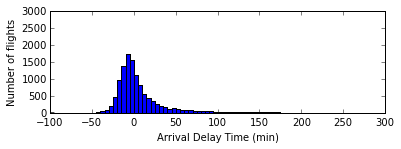

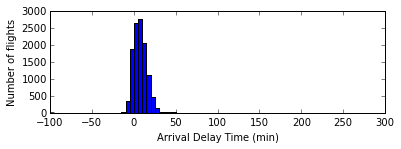

In [8]:
def plotPredict(y, y_pred):
    print "\nActual arrival delay time vs predicted arrival delay time"
    subplot(211)
    plt.axis([-100, 300, 0, 3000])
    xlabel('Arrival Delay Time (min)');
    ylabel('Number of flights');
    plt.hist(y, bins=np.arange(-100, 300 + 5, 5))
    plt.show()

    subplot(212)
    plt.axis([-100, 300, 0, 3000])
    xlabel('Arrival Delay Time (min)');
    ylabel('Number of flights');
    plt.hist(y_pred, bins=np.arange(-100, 300 + 5, 5))
    plt.show()

plotPredict(y_test, regressor.predict(X_test))
show()

From the distribution of the arrival delay time shown above, we can see that the distribution of the predicted arrival delay time is more centralized with shorter right tail, and the peak of the predicted arrival delay time is shifted to the right comparing to the actual arrival delay time. There is a small difference between the mean of the actual and predicted delay time (see below), however, the difference in the median value of predicted and actual delay time is about 9 minutes. To make the predicted distribution less centralized to mimic the distribution of actual data, one may increase learning rate to achieve that. However, increasing the learning rate will increase variance and thus RMSE.

The inability to improve the RMSE of predicted delay time seems not dependent on the model we used. Using random forest method and support vector machine with non-linear kernel also results in RMSE around 38 minutes, not meaningfully better than using average delay time from historical data as a prediction. It seems like we are predicting random events. One possible explanation is that the actual arrival delay time has a long tail to the right, to as large as 200 minutes. Such a long delay for a flight may be a random event, probably due to weather. This may cause a bias towards right when the model tries to fit the data. However, if we discard all flights with arrival delay time longer than 75 minutes and re-train the model, we would get both the RMSE of delay time predicted by gradient boosting method and by naive prediction decrease to 19 minutes. The predicted bias and RMSE are reduced, but so does the prediction using simple average!

In [9]:
print "Mean of actual delay time:", np.mean(y_test)
print "Mean of predicted delay time:", np.mean(regressor.predict(X_test))

print "Median of actual delay time:", np.median(y_test)
print "Median of predicted delay time:", np.median(regressor.predict(X_test))

Mean of actual delay time: 7.79316577724
Mean of predicted delay time: 7.41715045528
Median of actual delay time: -3.0
Median of predicted delay time: 6.52349188797


###Identifying delayed flights
The exact arrival delay time for individual flights seems not very predictable from our model because of its nature of large variance. However, note that people are more interested in avoiding the flights that arrived much later than scheduled time, and do not mind their flights actually arrived earlier than scheduled time. It would be more interesting to see how good the model identify the delayed flights. The data from BTS defined delay flights as flights that arrived more than 15 minutes later than their scheduled arrival time. Here I will use 15 minutes as a threshold and the predicted delay time obtained from the gradient boosting regression model to classify the flights to non-delayed and delayed flights.

One way to measure how good the model identifies the delayed flights is to calculate the so called F1 score, which is defined in statistics as the harmonic average of precision and recall, i.e. 1/F1 = 0.5*(1/precison + 1/recall). Precision (or positive predictive value) is defined as TP/(TP + FP), and recall (or sensitivity, or true positive rate) is defined as TP/(TP+FN), where TP, FP, and FN are the number of true positives, false positives, and false negatives, respectively. Here a positive refers to a delayed flight and a negative refers to non-delayed flight. Let us use the same training set above, but redo the 5-fold cross validation to find the learning rate that results in the optimized F1 score.

Cross validating...
Size of training set: 46473
learning rate, F1 score:
0.01 0.246971984704
0.0316227766017 0.355508768058
0.1 0.390113419059
0.316227766017 0.39418461087
1.0 0.361279107956
bp, bs: 0.316227766017 0.39418461087

Testing...
Size of out-of-sample test set: 11618

RMSE(y_train, y_train_pred), RMSE(y_val, y_val_pred)
28.9378834905 39.1892716063

Mean of y_train: 7.40632195038
Root mean squared error of naive prediction:  39.4783226137

Actual arrival delay time vs predicted arrival delay time


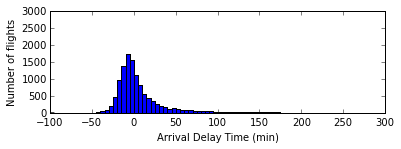

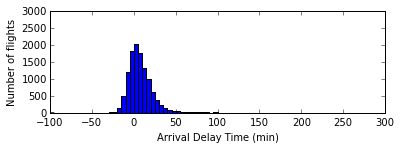


Training accuracy, validation accuracy:
0.80356335937 0.726803236357

Accuracy of naive prediction:  0.781459803753

Precision = 0.382711488733   Recall (or sensitivity) = 0.408034659315
F1 score: 0.394967594358


In [14]:
from sklearn.grid_search import GridSearchCV

def f1score(clf, X, y):
    #clf = clf.fit(X, y)
    y_pred = clf.predict(X)
    thres = 15.0
    yc = y > thres
    yc_pred = y_pred > thres
    
    # True positive rate = TP / (TP + FN), positive means delay
    tp = np.sum((yc == True) * (yc_pred == True)) 
    fn = np.sum((yc == True) * (yc_pred == False))
    TPR = float(tp) / (tp + fn) # true positive rate, also sensitivity, recall
    
    fp = np.sum((yc == False) * (yc_pred == True))
    tn = np.sum((yc == False) * (yc_pred == False))
    FPR = float(fp) / (fp + tn) # false positive rate, also fall-out
    
    PPV = float(tp) / (tp + fp) # positive predictive value, also precision
    F1 = 2.0 * PPV * TPR / (PPV + TPR)
    return (F1, PPV, TPR)

def classifyStats(regressor, X_train, y_train, X_val, y_val):
    # Calculating classification statistics from regression results
    y_val_pred = regressor.predict(X_val)
    y_train_pred = regressor.predict(X_train)
    
    print "\nTraining accuracy, validation accuracy:"
    thres = 15.0 # threshold for identifying delayed flights
    accu_train = np.sum((y_train > thres) == (y_train_pred > thres))*1.0 / len(y_train)
    accu_val = np.sum((y_val > thres) == (y_val_pred > thres))*1.0 / len(y_val)
    print accu_train, accu_val
    print "\nAccuracy of naive prediction: ", np.sum(y_val <= 15.0) * 1.0 / len(y_val)
    
    (F1, PPV, TPR) = f1score(regressor, X_val, y_val)
    print "\nPrecision =", PPV, "  Recall (or sensitivity) =", TPR
    
    return (accu_train,accu_val, PPV, TPR)

def crossValidate(X, y, lrs, n_fold = 5):
    # n-fold Cross validation with F1 score
    m = int(len(y)/n_fold)
    res = len(y) % n_fold
    X_bins = []
    y_bins = []
    for i in range(n_fold):
        m1 = i*m
        m2 = (i+1)*m
        X_bins.append(X[m1:m2])
        y_bins.append(y[m1:m2])
        
    for i in range(len(y) - m*n_fold):
        X_bins[i] = np.concatenate((X_bins[i], [X[m*n_fold + i]]), axis = 0)
        y_bins[i] = np.concatenate((y_bins[i], [y[m*n_fold + i]]), axis = 0)
    
    print "learning rate, F1 score:"
    f1_optimized = 0
    lr_optimized = 0.01
    for lr in lrs:
        f1sum = 0
        for i in range(n_fold):
            nlist = range(n_fold)
            nlist.remove(i)
            X_val = X_bins[i]
            y_val = y_bins[i]
            X_train = X_bins[nlist[0]]
            y_train = y_bins[nlist[0]]
            for j in nlist[1:]:
                X_train = np.concatenate((X_train, X_bins[j]), axis=0)
                y_train = np.concatenate((y_train, y_bins[j]), axis=0)
        
            clf = GradientBoostingRegressor(n_estimators = n_est, max_depth = 5,
                                            min_samples_split=2,
                                            learning_rate = lr, loss = 'ls')
            clf.fit(X_train, y_train)
            (f1, ppv, tpr) = f1score(clf, X_val, y_val)
            f1sum += f1
        f1mean = f1sum/n_fold
        print lr, f1mean
        if f1mean > f1_optimized:
            f1_optimized = f1mean
            lr_optimized = lr
    print "bp, bs:", lr_optimized, f1_optimized
    
    return (lr_optimized, f1_optimized)

# Training and cross validation using F1 score
print "Cross validating..."
print "Size of training set:", len(y_train)

#print "Size of out-of-sample test set:", len(y_test)
n_est = 200
n_fold = 2

# Get optimized learning rate from cross validation
bp, bs = crossValidate(X_train, y_train, np.logspace(-2, 0, num=5), n_fold = 5)

regressor = GradientBoostingRegressor(n_estimators = n_est, max_depth = 5, min_samples_split=1,
                                      learning_rate = bp, loss = 'ls')
regressor = regressor.fit(X_train, y_train)

print "\nTesting..."
print "Size of out-of-sample test set:", len(y_test)
outPredicted(regressor, X_train, y_train, X_test, y_test)
plotPredict(y_test, regressor.predict(X_test))

(accu_train, accu_val, PPV, TPR) = classifyStats(regressor, X_train, y_train, X_test, y_test)
print "F1 score:", 2.0 * PPV * TPR / (PPV + TPR)

The results above shows that the learning rate that yield the optimized F1 score is around 0.3. Applying the model trained with this learning rate to the test set, we can get precision, sensitivity (or recall), and F1 around 0.4. The results indicate that the best model trained here will indentify 40% of the actual delayed flights correctly. Also around 40% of all predicted delayed flights are the ones that are actual delayed flights. The rate is not high, but it is much better than naive prediction with simple average, which will predict all flights to be non-delayed flights since the average arrival delay time of the training examples is 7.4 minutes, smaller than 15 minutes.

In addition, the width of the distribution of the predicted arrival delay time is closer to that of actual delay time than the one predicted with learning rate (0.03) that aims to optimize RMSE. The peak of the predicted delay time is also closer to the actual value. Although this comes with a slight cost in the overall accuracy (rate of classifying non-delayed and delayed flights correctly), probabaly with more false positives, the model obtained with learning rate optimized by F1 score appears to predict better overall than the model with learning rate optimized by RMSE.

In [15]:
print "Mean of actual delay time:", np.mean(y_test)
print "Mean of predicted delay time:", np.mean(regressor.predict(X_test))

print "Median of actual delay time:", np.median(y_test)
print "Median of predicted delay time:", np.median(regressor.predict(X_test))

Mean of actual delay time: 7.79316577724
Mean of predicted delay time: 7.5813122199
Median of actual delay time: -3.0
Median of predicted delay time: 5.02521896388


### Feature importances for arrival flight delay

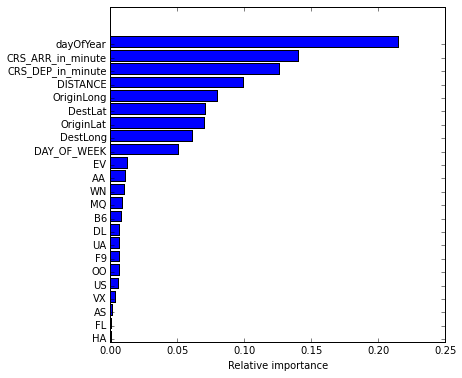

In [16]:
colnames = mlData.columns
colnames = colnames[:-2]

plt.rcParams["figure.figsize"] = [6,6]
indices = np.argsort(regressor.feature_importances_)
plt.barh(np.arange(len(colnames)), regressor.feature_importances_[indices])
plt.yticks(np.arange(len(colnames)) + 0.2, np.array(colnames)[indices])
_ = plt.xlabel('Relative importance')
show()

One of the interesting results by the gradient boosting model is the feature importance. The results show that the most important features that impact the delay time are day of year, scheduled arrival and departure time, followed by distance, longitude and latitude of departure airport and arrival airport, and day of week. Surprisingly, the importance of airlines to the on time performance of a flight is very low.

The importance of day of year and arrival or departure time to the delay time is understandable since delay of flights tend to occur in proximity of time or day, especially if it is because of weather or air traffic. If we group the data by the reason of delay for those flights with more than 15 minutes in arrival delay time, we would find that the most common reasons of delay are late aircraft delay, carrier delay (mechanical issue, etc), and NAS delay (non-extreme weather, air traffic, etc.). Carrier delay occurs to single flight, however, aircraft delay and NAS delay would involved with multiple flights in a narrow window of time or day. If the origins of these delays occur randomly during the year, it might not predict well for the current year based on data of previous years. Predictions of delay time of flights based on data of other flights within the same year should be good if the distribution is well-sampled.

#### Importance of time of day on arrival delay
Since the findings show that departure time and arrival time are two of the most important features that affect the on time performance, let us plot the mean arrival delay time over an hour block as a function of departure time in a day.

On Time Performance vs Scheduled Departure Time:


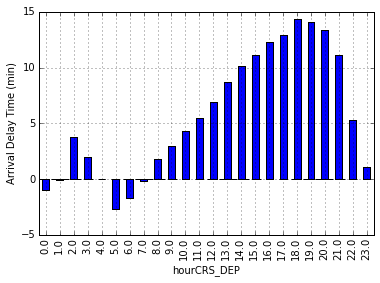

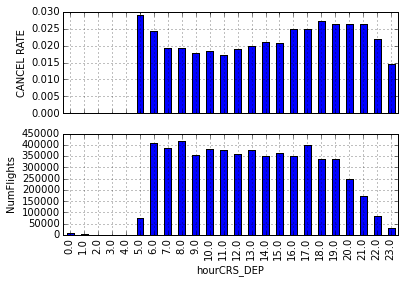

In [17]:
def plotDelayTime(data, xname):
    # Plot histogram of arrival delay time
    subplot(111)
    data.DelayArrMean.plot(kind='bar')
    xlabel(xname);
    ylabel('Arrival Delay Time (min)');
    show()

def plotCancelRate(data, xname):
    # Plot histogram of cancellation rate
    subplot(211)
    data.CancelRate.plot(kind='bar')
    xlabel(xname);
    ylabel('CANCEL RATE');
    subplot(212)
    data.NumFlights.plot(kind='bar')
    ylabel('NumFlights');
    show()

col = 'ARR_DELAY'
colGroup = 'hourCRS_DEP'
year = 2014
input_file = str(year) + '-01.csv'
performance = readData(input_file, col, colGroup)

perform_monthly = [performance]

nmonth = 12
for i in range(1, nmonth):
    input_file = str(year) + '-' + str(i+1).zfill(2) + '.csv'
    temp = readData(input_file, col, colGroup)
    perform_monthly.append(temp)
    performance += temp
    
print 'On Time Performance vs Scheduled Departure Time:'
    
performance['CancelRate'] = performance.NumCancelled / performance.NumFlights
    
# Average delay minutes for arrival flights
performance['DelayArrMean'] = performance.DelayArrSum / performance.NumArrived
performance['DelayArrVar'] = performance.DelayArrSum2 / (performance.NumArrived-1)
performance['DelayArrStd'] = performance.DelayArrVar.apply(np.sqrt)
performance['DelayArrSte'] = performance.DelayArrStd / performance.NumArrived.apply(np.sqrt)

plt.rcParams["figure.figsize"] = [6,4]
plotDelayTime(performance, colGroup)
plotCancelRate(performance, colGroup)

The plot above show the departure-time dependence of arrival delay, cancellation rate, and number of flights. It is obvious that flights with scheduled departure time during rush hours in the afternoon (17:00 - 20:00) are most likely to be delayed. The number of scheduled flights are at similar levels between 6:00 and 19:00, but the average arrival delay time steadly increases over time and reaches a peak at 18:00. On the other hand, the figure of cancellation rate shows that in addition to departure time during afternoon rush hours, early morning (5-6am) flights are the flights most likely to get cancelled, probably because of low volume of travellers in the flight. 

### Predictions for flights in 2015
Finally, let us see how the model we trained predicts the on time performance for flights in the first three months of 2015.

In [18]:
# Generate test set from data in 2015
year = 2015
col = 'ARR_DELAY'
ratio2 = 0.01
input_file = str(year) + '-01.csv'
print('Reading test data...')
testData = sampleData(input_file, col, ratio2)

nmonth = 3
for i in range(1, nmonth):
    input_file = str(year) + '-' + str(i+1).zfill(2) + '.csv'
    temp = sampleData(input_file, col, ratio)
    testData = testData.append(temp, ignore_index=True)

print('Processing data...')
testData = processData(testData)

test = testData.reindex(np.random.permutation(testData.index))
test = test.reset_index().values
y_test = test[:,col_y]
X_test = test[:,1:-2]

Reading test data...
Processing data...
First five rows with newly defined features for training:
   dayOfYear  DAY_OF_WEEK  DISTANCE  CRS_DEP_in_minute  CRS_ARR_in_minute  \
0         27            2       247               1375               1437   
1         23            5       325               1270               1340   
2         30            5       119                480                537   
3         14            3       298                680                817   
4         27            2      1448                360                532   

   OriginLat  OriginLong    DestLat    DestLong  AA  OO  DL  HA  WN  AS  US  \
0  32.895951  -97.037200  29.533694  -98.469778   1   0   0   0   0   0   0   
1  34.200619 -118.358497  37.721291 -122.220717   0   0   0   0   1   0   0   
2  35.138455 -111.671218  33.434167 -112.008056   0   1   0   0   0   0   0   
3  39.858408 -104.667002  38.844942  -99.274034   0   1   0   0   0   0   0   
4  47.448982 -122.309313  61.174320 -149.996

Size of test set: 14020

RMSE(y_test, y_test_pred): 43.1668471679

Root mean squared error of naive prediction:  39.4554060647

Training accuracy, validation accuracy:
0.80356335937 0.694436519258

Accuracy of naive prediction:  0.799001426534

Precision = 0.291997729852   Recall (or sensitivity) = 0.36515259049
F1 score: 0.324503311258

Actual arrival delay time vs predicted arrival delay time


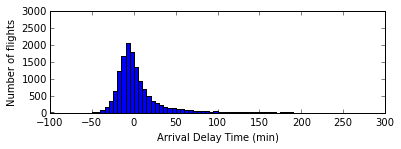

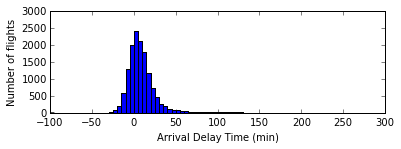

In [19]:
# Predict results
print "Size of test set:", len(y_test)
y_test_pred = regressor.predict(X_test)
print "\nRMSE(y_test, y_test_pred):", np.sqrt(mean_squared_error(y_test, y_test_pred))
    
naive_pred = np.mean(y_train)
naive_error = np.std(y_test - naive_pred)

print "\nRoot mean squared error of naive prediction: ", naive_error

(accu_train, accu_val, PPV, TPR) = classifyStats(regressor, X_train, y_train, X_test, y_test)
print "F1 score:", 2.0 * PPV * TPR / (PPV + TPR)

plotPredict(y_test, regressor.predict(X_test))

The test set here is extracted randomly from the data in the first three months in 2015. The accuracy of predictions for 2015 flights appears not as good as predictions for 2014. One reason is that we only have the first three months of 2015 data, not sampled over a whole year. However, the main reason is that we are predicting 2015 results based on 2014 data. If weather plays a large role in the origin of arrival delays, it is reasonable that the predicted flight delays will be less accurate based on past data. A potential solution for improving the prediction might be including more data such as weather data in the training and weather forecast of near future for predicting performance of future flights.

### Conclusion
In summary, the historical flight data provides insight into what factors impact the on time performance. The statistics from the data agrees with the common perception that flight tends to delay during rush hours in the afternoon and during peak season of travels. From the traveller's standpoint, it is best to fly in mid morning to avoid arrival delay. Choice of airlines is not the important factor comparing to other features if one wants to be on time, although the preliminary statistics did show performance differences between airlines. Besides the possibility that different airlines might operated flights departing at different time blocks during the day, one important factor is the location of markets. Some airlines operates flights that are centered around cities that are less likely to be affected by weather, for example, Hawaii Airlines (HA) and Alaska Airlines (AS), while some airlines have flights centered around locations that are more likely to endure bad weather and busy traffic (such as Chicago).

Although the on time performance of flights appears to be dependent on some important features, it is surprising that there is a large mean squared error when predicting individual flight performance based on data of other flights. Predicting flight delays can somewhat be done by the gradient boosting model with learning rate optimized with F1 score, though with sensitivity < 50%. Perhaps the prediction can be drastically improved if weather information can be incorporated into the learning model. In addition, it may be necessary to run over many years of data to avoid overfitting to a single year data that might over emphasize the importance of day of year that might be skewed by random events, like weather, in a particular year.